# OpenCL Thread Coarsening

This notebook contains the experiments for Case Study B - using deep learning to predict thread coarsening factor for OpenCL kernels, without hand engineered features.

## 1. Runtime Data

We use author-provided runtime data from the PACT'14 paper that we compare against [1].

> [1] Magni, A., Dubach, C., & O’Boyle, M. (2014). [Automatic Optimization of Thread-Coarsening for Graphics Processors](http://www.research.ed.ac.uk/portal/files/19958629/magni14pact.pdf). In PACT. ACM.

The data consists of runtimes from 17 benchmarks accross 4 experimental platforms:

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5)

df = pd.read_csv("../data/case-study-b/pact-2014-runtimes.csv")
df

,kernel,cf,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,runtime_Fermi,runtime_Kepler,runtime_Cypress,runtime_Tahiti,src,seq
0,blackscholes,1,1.994918,-0.810402,-2.206370,3.217486,-2.193143,2.374925,0.174607,1321696.0,1381120.0,1783889.0,975555.0,"__kernel void A(__global float* a, __global fl...",[ 59 1 118 1 31 7 58 1 80 9 1 ...
1,blackscholes,2,2.133716,-1.493068,-1.286520,3.075195,-0.381715,0.677804,0.960159,1238176.0,1222336.0,1849444.0,962963.0,"__kernel void A(__global float* a, __global fl...",[ 59 1 118 1 31 7 58 1 80 9 1 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,nbody,8,-1.753095,-0.428577,-4.534866,-1.279360,0.941490,1.106185,-0.531706,332913280.0,30859456.0,35734111.0,36427408.0,"__kernel void A(__global float4* a, __global f...",[ 59 1 118 1 31 7 58 1 80 19 9 ...
88,nbody,16,-4.279616,-1.328454,-6.529448,-1.415595,2.290164,-0.138573,0.294633,NaN,NaN,42521556.0,65451704.0,"__kernel void A(__global float4* a, __global f...",[ 59 1 118 1 31 7 58 1 80 19 9 ...


From this we can derive the "oracle" thread coarsening factors, i.e. the thread coarsening factors which provided the lowest runtime on each of the four architectures, for each of the 17 benchmarks:

In [2]:
oracles = pd.read_csv("../data/case-study-b/pact-2014-oracles.csv")
oracles

,kernel,cf_Fermi,runtime_Fermi,cf_Kepler,runtime_Kepler,cf_Cypress,runtime_Cypress,cf_Tahiti,runtime_Tahiti
0,binarySearch,1.0,213216.0,16.0,165248.0,2.0,290889.0,4.0,178518.0
1,blackscholes,8.0,1148128.0,4.0,1179008.0,1.0,1783889.0,2.0,962963.0
...,...,...,...,...,...,...,...,...,...
15,spmv,1.0,36224.0,1.0,52896.0,1.0,82000.0,1.0,64592.0
16,stencil,2.0,4295104.0,1.0,4330912.0,1.0,10420555.0,1.0,5200148.0


## 2. Predictive Models

We define a base class for implementing predictive models for thread coarsening:

In [3]:
import numpy as np
from clgen import _atomizer as clgen

class ThreadCoarseningModel(object):
    """
    A model for predicting OpenCL thread coarsening factors.

    Attributes
    ----------
    __name__ : str
        Model name
    __basename__ : str
        Shortened name, used for files
    """
    __name__ = None
    __basename__ = None

    def init(self, seed: int) -> None:
        """
        Initialize the model.

        Do whatever is required to setup a new thread coarsening model here.
        This method is called prior to training and predicting.
        This method may be omitted if no initial setup is required.

        Parameters
        ----------
        seed : int
            The seed value used to reproducible results. May be 'None',
            indicating that no seed is to be used.
        """
        pass

    def save(self, outpath: str) -> None:
        """
        Save model state.

        This must capture all of the relevant state of the model. It is up
        to implementing classes to determine how best to save the model.

        Parameters
        ----------
        outpath : str
            The path to save the model state to.
        """
        raise NotImplementedError

    def restore(self, inpath: str) -> None:
        """
        Load a trained model from file.

        This is called in place of init() if a saved model file exists. It
        must restore all of the required model state.

        Parameters
        ----------
        inpath : str
            The path to load the model from. This is the same path as
            was passed to save() to create the file.
        """
        raise NotImplementedError

    def train(self, cascading_features: np.array, cascading_y: np.array,
              sequences: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        """
        Train a model.

        Parameters
        ----------
        cascading_features : np.array
            An array of feature vectors of shape (n,7,7). Used for the cascading
            model, there are 7 vectors of 7 features for each benchmark, one for
            each coarsening factor.

        cascading_y : np.array
            An array of classification labels of shape(n,7). Used for the cascading
            model.

        sequences : np.array
            An array of encoded source code sequences of shape (n,seq_length).

        y_1hot : np.array
            An array of optimal coarsening factors of shape (n,6), in 1-hot encoding.

        verbose: bool, optional
            Whether to print verbose status messages during training.
        """
        raise NotImplementedError

    def predict(self, cascading_features: np.array, sequences: np.array) -> np.array:
        """
        Make predictions for programs.

        Parameters
        ----------
        cascading_features : np.array
            An array of feature vectors of shape (n,7,7). Used for the cascading
            model, there are 7 vectors of 7 features for each benchmark, one for
            each coarsening factor.

        sequences : np.array
            An array of encoded source code sequences of shape (n,seq_length).

        Returns
        -------
        np.array
            Predicted 'y' values (optimal thread coarsening factors) with shape (n,1).
        """
        raise NotImplementedError


/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/elandg/eecs583-pape

We also define some utility code which we will use later:

In [4]:
cfs = [1, 2, 4, 8, 16, 32]  # thread coarsening factors

def get_onehot(df, platform):
    hot = np.zeros((len(df), len(cfs)), dtype=np.int32)
    for i, cf in enumerate(df[f"cf_{platform}"]):
        hot[i][cfs.index(cf)] = 1

    return hot


def get_magni_features(df, oracles, platform):
    """
    Assemble cascading data.
    """
    X_cc, y_cc, = [], []
    for kernel in sorted(set(df["kernel"])):
        _df = df[df["kernel"] == kernel]

        oracle_cf = int(oracles[oracles["kernel"] == kernel][f"cf_{platform}"].values[0])

        feature_vectors = np.asarray([
            _df['PCA1'].values,
            _df['PCA2'].values,
            _df['PCA3'].values,
            _df['PCA4'].values,
            _df['PCA5'].values,
            _df['PCA6'].values,
            _df['PCA7'].values,
        ]).T
                
        X_cc.append(feature_vectors)
        y = []
        cfs__ = []
        for i, cf in enumerate(cfs[:len(feature_vectors)]):
            y_ = 1 if cf < oracle_cf else 0
            y.append(y_)
        y_cc.append(y)
    
        assert len(feature_vectors) == len(y)
        
    assert len(X_cc) == len(y_cc) == 17
    
    return np.asarray(X_cc), np.asarray(y_cc)


def encode_srcs(srcs):
    """ encode and pad source code for learning """
    from keras.preprocessing.sequence import pad_sequences
    
    seqs = [atomizer.atomize(src) for src in srcs]
    pad_val = atomizer.vocab_size
    encoded = np.array(pad_sequences(seqs, maxlen=1024, value=pad_val))
    return np.vstack([np.expand_dims(x, axis=0) for x in encoded])


def platform2str(platform):
    if platform == "Fermi":
        return "NVIDIA GTX 480"
    elif platform == "Kepler":
        return "NVIDIA Tesla K20c"
    elif platform == "Cypress":
        return "AMD Radeon HD 5900"
    elif platform == "Tahiti":
        return "AMD Tahiti 7970"
    else:
        raise LookupError

## 3. Experimental Methodology

For reproducible results:

In [5]:
seed = 204

The source encoder (see the *'Language Model.ipynb'* notebook for details):

In [6]:
from clgen import Language

srcs = '\n'.join(pd.read_csv("../data/case-study-a/cgo17-amd.csv")['src'].values)
atomizer = clgen.GreedyAtomizer.from_text(lang=Language.from_str("opencl"), text=srcs)
atomizer

GreedyAtomizer[128 tokens]

In [7]:
import pickle
import sys
from labm8 import fs
from sklearn.model_selection import KFold, train_test_split

def evaluate(model):
    # report progress:
    from progressbar import ProgressBar
    progressbar = [0, ProgressBar(max_value=68)]
    
    data = []
    
    X_seq = None  # defer sequence encoding (it's expensive)
    
    for i, platform in enumerate(["Cypress", "Tahiti", "Fermi", "Kepler"]):
        platform_name = platform2str(platform)
                
        # load data
        oracle_runtimes = np.array([float(x) for x in oracles["runtime_" + platform]])
        y = np.array([int(x) for x in oracles["cf_" + platform]], dtype=np.int32)
        y_1hot = get_onehot(oracles, platform)
        X_cc, y_cc = get_magni_features(df, oracles, platform)
        
        # LOOCV
        kf = KFold(n_splits=len(y), shuffle=False)
    
        for j, (train_index, test_index) in enumerate(kf.split(y)):
        # indices = np.arange(len(y))
        # train_index, test_index = train_test_split(indices, shuffle=True, random_state=seed, test_size=0.25)
            kernel = sorted(set(df["kernel"]))[test_index[0]]

            model_name = model.__name__
            model_basename = model.__basename__
            
            model_path = f"../data/case-study-b/models/{model_basename}-{platform}-new-test.model"
            predictions_path = f"../data/case-study-b/predictions/{model_basename}-{platform}-new-test.result"  

            if False:
            # if fs.exists(predictions_path):
                # load result from cache
                with open(predictions_path, 'rb') as infile:
                    p = pickle.load(infile)
            else:
                if False:
                # if fs.exists(model_path):
                    # load a trained model from cache
                    model.restore(model_path)
                else:
                    # encode source codes
                    if X_seq is None:
                        X_seq = encode_srcs(df["src"].values)

                    # create a new model and train it
                    model.init(seed=seed)
                    model.train(cascading_features=np.concatenate(X_cc[train_index]),
                                cascading_y=np.concatenate(y_cc[train_index]),
                                sequences=X_seq[train_index],
                                verbose=True, # TODO
                                y_1hot=y_1hot[train_index])

                    # cache the model
                    fs.mkdir(fs.dirname(model_path))
                    model.save(model_path)

                # make prediction
                p = model.predict(cascading_features=X_cc[test_index[0]], sequences=X_seq[test_index])[0]
                p = min(p, 2 ** (len(X_cc[test_index[0]]) - 1))
                
                # cache the prediction
                fs.mkdir(fs.dirname(predictions_path))
                with open(predictions_path, 'wb') as outfile:
                    pickle.dump(p, outfile)
                    
            # oracle prediction
            o = y[test_index[0]]
            correct = p == o

            # get runtime without thread coarsening
            row = df[(df["kernel"] == kernel) & (df["cf"] == 1)]
            assert(len(row) == 1)  # sanity check
            nocf_runtime = float(row["runtime_" + platform])

            # get runtime of prediction
            row = df[(df["kernel"] == kernel) & (df["cf"] == p)]
            assert(len(row) == 1)  # sanity check
            p_runtime = float(row["runtime_" + platform])
            
            # get runtime of oracle coarsening factor
            o_runtime = oracle_runtimes[test_index[0]]

            # speedup and % oracle
            s_oracle = nocf_runtime / o_runtime
            p_speedup = nocf_runtime / p_runtime
            p_oracle = o_runtime / p_runtime

            # record result
            data.append({
                "Model": model_name,
                "Platform": platform_name,
                "Kernel": kernel,
                "Oracle-CF": o,
                "Predicted-CF": p,
                "Speedup": p_speedup,
                "Oracle": p_oracle
            })
            
            progressbar[0] += 1  # update progress bar
            progressbar[1].update(progressbar[0])

    return pd.DataFrame(data, columns=[
        "Model", "Platform", "Kernel", "Oracle-CF", "Predicted-CF", "Speedup", "Oracle"])

### 3.1. Magni et al. Model

The Magni et al. predictive model.

Described in publication:

> [1] Magni, A., Dubach, C., & O’Boyle, M. (2014). [Automatic Optimization of Thread-Coarsening for Graphics Processors](http://www.research.ed.ac.uk/portal/files/19958629/magni14pact.pdf). In PACT. ACM.

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold

# during grid search, not all parameters will converge. Ignore these warnings
from warnings import filterwarnings
from sklearn.exceptions import ConvergenceWarning
filterwarnings("ignore", category=ConvergenceWarning)

class Magni(ThreadCoarseningModel):
    __name__ = "Magni et al."
    __basename__ = "magni"

    def init(self, seed: int=None):
        # the neural network
        nn = MLPClassifier(random_state=seed, shuffle=True)

        # cross-validation over the training set. We train on 16 programs,
        # so with k=16 and no shuffling of the data, we're performing
        # nested leave-one-out cross-validation
        inner_cv = KFold(n_splits=16, shuffle=False)

        # hyper-parameter combinations to try
        params = {
            "max_iter": [200, 500, 1000, 2000],
            "hidden_layer_sizes": [
                (32,),
                (32, 32),
                (32, 32, 32),
                (64,),
                (64, 64),
                (64, 64, 64),
                (128,),
                (128, 128),
                (128, 128, 128),
                (256,),
                (256, 256),
                (256, 256, 256),
            ]
        }

        self.model = GridSearchCV(nn, cv=inner_cv, param_grid=params, n_jobs=-1)

    def save(self, outpath):
        with open(outpath, 'wb') as outfile:
            pickle.dump(self.model, outfile)

    def restore(self, inpath):
        with open(inpath, 'rb') as infile:
            self.model = pickle.load(infile)

    def train(self, cascading_features: np.array, cascading_y: np.array,
              sequences: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        self.model.fit(cascading_features, cascading_y)

    def predict(self, cascading_features: np.array, sequences: np.array) -> np.array:
        # we only support leave-one-out cross-validation (implementation detail):
        assert(len(sequences) == 1)

        # The binary cascading model:
        #
        # iteratively apply thread coarsening, using a new feature vector
        # every time coarsening is applied
        for i in range(len(cascading_features)):
            # predict whether to coarsen, using the program features of
            # the current coarsening level:
            should_coarsen = self.model.predict([cascading_features[i]])[0]
            if not should_coarsen:
                break
        p = cfs[i]
        return [cfs[i]]


In [9]:
# print("Evaluating Magni et al. ...", file=sys.stderr)
# magni = evaluate(Magni())
# magni.groupby('Platform')['Platform', 'Speedup', 'Oracle'].mean()

### 3.2. DeepTune

We predict thread coarsening factor directly from raw source code inputs:

In [10]:
class DeepTune(ThreadCoarseningModel):
    __name__ = "DeepTune"
    __basename__ = "deeptune"

    def init(self, seed: int=None):
        from keras.layers import Input, Dropout, Embedding, merge, LSTM, Dense, Conv1D, GlobalMaxPooling1D
        from keras.layers.normalization import BatchNormalization
        from keras.models import Model, Sequential, load_model
    
        np.random.seed(seed)
    
        # Vocabulary has a padding character
        vocab_size = atomizer.vocab_size + 1

        # Language model. Takes as inputs source code sequences.
        seq_inputs = Input(shape=(1024,), dtype="int32")
        x = Embedding(input_dim=vocab_size, input_length=1024,
                      output_dim=64, name="embedding")(seq_inputs)
        x = LSTM(64, return_sequences=True, implementation=1, name="lstm_1")(x)
        x = LSTM(64, implementation=1, name="lstm_2")(x)
        # x = Conv1D(32, 9, name="conv_1")(x)
        # x = Conv1D(32, 9, name="conv_2")(x)
        # x = GlobalMaxPooling1D()(x)
        # Heuristic model. Takes as inputs the language model,
        #   outputs 1-of-6 thread coarsening factor
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        outputs = Dense(6, activation="sigmoid")(x)

        self.model = Model(inputs=seq_inputs, outputs=outputs)
        self.model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

    def save(self, outpath: str):
        self.model.save(outpath)

    def restore(self, inpath: str):
        self.model = load_model(inpath)
        
    def train(self, cascading_features: np.array, cascading_y: np.array,
              sequences: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        self.model.fit(sequences, y_1hot, epochs=50, batch_size=64, verbose=verbose, shuffle=True)

    def predict(self, cascading_features: np.array, sequences: np.array) -> np.array:
        # directly predict optimal thread coarsening factor from source sequences:
        p = np.array(self.model.predict(sequences, batch_size=64, verbose=0))
        indices = [np.argmax(x) for x in p]
        return [cfs[x] for x in indices]

An overview of the DeepTune model, showing the number of parameters in each layer, used to construct Table 5 in the paper:

In [11]:
deeptune_model = DeepTune()
deeptune_model.init(seed)
deeptune_model.model.summary()

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1024, 64)          8256      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
d

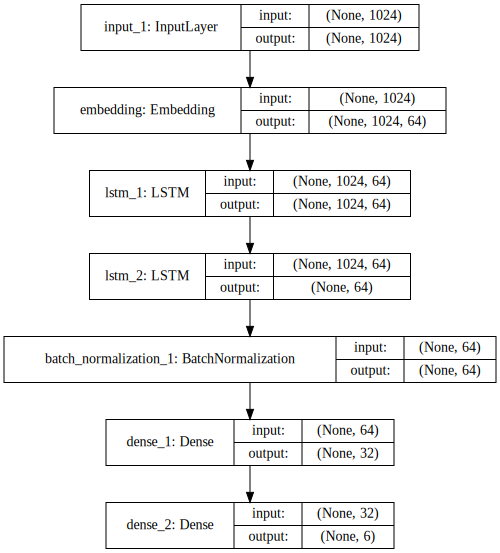

In [12]:
def isnotebook():
    # written by @mtd http://stackoverflow.com/a/39662359
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':  # Jupyter notebook or qtconsole?
            return True
        elif shell == 'TerminalInteractiveShell':  # Terminal running IPython?
            return False
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


img = None
if isnotebook():
    from keras.utils.vis_utils import model_to_dot
    from IPython.display import SVG
    img = SVG(model_to_dot(deeptune_model.model, show_shapes=True).create(prog='dot', format='svg'))
img

Summary of results:

In [13]:
print("Evaluating DeepTune ...", file=sys.stderr)
deeptune = evaluate(DeepTune())
deeptune.groupby('Platform')['Platform', 'Speedup', 'Oracle'].mean()

Evaluating DeepTune ...
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/50


2022-12-14 11:19:28.469299: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-14 11:19:28.488592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2808000000 Hz
2022-12-14 11:19:28.494172: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x73efa90 executing computations on platform Host. Devices:
2022-12-14 11:19:28.494331: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-12-14 11:19:30.474439: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

12/12 [==============================] - 20s 2s/step - loss: 1.7951 - acc: 0.2500
Epoch 2/50
12/12 [==============================] - 11s 915ms/step - loss: 1.7711 - acc: 0.2500
Epoch 3/50
12/12 [==============================] - 11s 939ms/step - loss: 1.7500 - acc: 0.4167
Epoch 4/50
12/12 [==============================] - 11s 877ms/step - loss: 1.7266 - acc: 0.4167
Epoch 5/50
12/12 [==============================] - 10s 839ms/step - loss: 1.6994 - acc: 0.4167
Epoch 6/50
12/12 [==============================] - 10s 803ms/step - loss: 1.6683 - acc: 0.4167
Epoch 7/50
12/12 [==============================] - 9s 788ms/step - loss: 1.6337 - acc: 0.4167
Epoch 8/50
12/12 [==============================] - 10s 824ms/step - loss: 1.5934 - acc: 0.4167
Epoch 9/50
12/12 [==============================] - 10s 842ms/step - loss: 1.5476 - acc: 0.4167
Epoch 10/50
12/12 [==============================] - 10s 799ms/step - loss: 1.4991 - acc: 0.4167
Epoch 11/50
12/12 [==============================] - 1

  0% (0 of 68) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
12/12 [==============================] - 21s 2s/step - loss: 1.8040 - acc: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 12s 1s/step - loss: 1.7888 - acc: 0.3333
Epoch 3/50
12/12 [==============================] - 13s 1s/step - loss: 1.7742 - acc: 0.3333
Epoch 4/50
12/12 [==============================] - 12s 981ms/step - loss: 1.7620 - acc: 0.4167
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 1.7514 - acc: 0.4167
Epoch 6/50
12/12 [==============================] - 10s 853ms/step - loss: 1.7375 - acc: 0.4167
Epoch 7/50
12/12 [==============================] - 21s 2s/step - loss: 1.7200 - acc: 0.4167
Epoch 8/50
12/12 [==============================] - 13s 1s/step - loss: 1.6993 - acc: 0.4167
Epoch 9/50
12/12 [==============================] - 12s 974ms/step - loss: 1.6749 - acc: 0.4167
Epoch 10/50
12/12 [==============================] - 14s 1s/step - loss: 1.6471 - acc: 0.4167
Epoch 11/50
12/12 [==============================] - 12s

  2% (2 of 68) |                         | Elapsed Time: 0:10:24 ETA:   5:43:14/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
12/12 [==============================] - 27s 2s/step - loss: 1.7902 - acc: 0.0833
Epoch 2/50
12/12 [==============================] - 9s 733ms/step - loss: 1.7682 - acc: 0.3333
Epoch 3/50
12/12 [==============================] - 9s 735ms/step - loss: 1.7496 - acc: 0.4167
Epoch 4/50
12/12 [==============================] - 11s 952ms/step - loss: 1.7290 - acc: 0.4167
Epoch 5/50
12/12 [==============================] - 8s 664ms/step - loss: 1.7047 - acc: 0.4167
Epoch 6/50
12/12 [==============================] - 8s 676ms/step - loss: 1.6769 - acc: 0.5000
Epoch 7/50
12/12 [==============================] - 8s 675ms/step - loss: 1.6457 - acc: 0.5000
Epoch 8/50
12/12 [==============================] - 11s 953ms/step - loss: 1.6112 - acc: 0.5000
Epoch 9/50
12/12 [==============================] - 9s 717ms/step - loss: 1.5739 - acc: 0.5000
Epoch 10/50
12/12 [==============================] - 8s 678ms/step - loss: 1.5358 - acc: 0.5000
Epoch 11/50
12/12 [==============================

  4% (3 of 68) |#                        | Elapsed Time: 0:19:05 ETA:   9:24:46/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
12/12 [==============================] - 23s 2s/step - loss: 1.7938 - acc: 0.0833
Epoch 2/50
12/12 [==============================] - 11s 914ms/step - loss: 1.7726 - acc: 0.1667
Epoch 3/50
12/12 [==============================] - 11s 905ms/step - loss: 1.7542 - acc: 0.5000
Epoch 4/50
12/12 [==============================] - 11s 939ms/step - loss: 1.7342 - acc: 0.5833
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 1.7118 - acc: 0.5833
Epoch 6/50
12/12 [==============================] - 11s 886ms/step - loss: 1.6860 - acc: 0.5833
Epoch 7/50
12/12 [==============================] - 12s 964ms/step - loss: 1.6560 - acc: 0.5833
Epoch 8/50
12/12 [==============================] - 11s 915ms/step - loss: 1.6223 - acc: 0.5833
Epoch 9/50
12/12 [==============================] - 12s 990ms/step - loss: 1.5853 - acc: 0.5833
Epoch 10/50
12/12 [==============================] - 10s 864ms/step - loss: 1.5471 - acc: 0.5833
Epoch 11/50
12/12 [==========================

  5% (4 of 68) |#                        | Elapsed Time: 0:29:18 ETA:  10:54:30/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Speedup,Oracle
Platform,,
AMD Radeon HD 5900,1.769493,1.000000
AMD Tahiti 7970,1.385804,0.637469
NVIDIA GTX 480,1.121572,0.964789
NVIDIA Tesla K20c,1.000000,0.901163


### 3.3. DeepTune-TL

As described in Section 4.3. of the paper, we use *Transfer Learning* to leverage information gained from one optimization problem for another. To do this, we simply initialize the language model with the weights learned for Case Study A. See '*Case Study A.ipynb*' for the code to produce these weights. Apart from initializing the weights from the other optimization task, the model remains unchanged:

In [14]:
class DeepTune_TL(DeepTune):
    __name__ = "DeepTune-TL"
    __basename__ = "deeptune_tl"

    starting_weights = "../data/case-study-b/case-study-a-weights.h5"

    def init(self, *args, **kwargs):
        super(DeepTune_TL, self).init(*args, **kwargs)
        self.model.load_weights(self.starting_weights, by_name=True)

In [15]:
print("Evaluating DeepTune-TL ...", file=sys.stderr)
deeptune_tl = evaluate(DeepTune_TL())
deeptune_tl.groupby('Platform')['Platform', 'Speedup', 'Oracle'].mean()

Evaluating DeepTune-TL ...
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
12/12 [==============================] - 20s 2s/step - loss: 1.7965 - acc: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 13s 1s/step - loss: 1.7706 - acc: 0.3333
Epoch 3/50
12/12 [==============================] - 9s 775ms/step - loss: 1.7478 - acc: 0.4167
Epoch 4/50
12/12 [==============================] - 8s 702ms/step - loss: 1.7246 - acc: 0.4167
Epoch 5/50
12/12 [==============================] - 8s 696ms/step - loss: 1.6980 - acc: 0.4167
Epoch 6/50
12/12 [==============================] - 9s 739ms/step - loss: 1.6675 - acc: 0.4167
Epoch 7/50
12/12 [==============================] - 8s 679ms/step - loss: 1.6328 - acc: 0.4167
Epoch 8/50
12/12 [==============================] - 11s 947ms/step - loss: 1.5944 - acc: 0.4167
Epoch 9/50
12/12 [==============================] - 10s 844ms/step - loss: 1.5525 - acc: 0.4167
Epoch 10/50
12/12 [==============================] - 8s 697ms/step - loss: 1.5083 - acc: 0.4167
Epoch 11/50
12/12 [============================

KeyboardInterrupt: 

## Evaluation

Average Speedup and Oracle of each model across all platforms:

In [ ]:
d = np.array([
    # magni[['Speedup', 'Oracle']].mean(),
    deeptune[['Speedup', 'Oracle']].mean(),
    deeptune_tl[['Speedup', 'Oracle']].mean(),
]).T

pd.DataFrame(d, columns=["DeepTune", "DeepTune-TL"], index=["Speedup", "Oracle"])
# pd.DataFrame(d, columns=["Magni et al.", "DeepTune", "DeepTune-TL"], index=["Speedup", "Oracle"])

## 4. Evaluation

### 4.1. Speedups

In [ ]:
d = []
# d.append(np.append(magni.groupby(['Platform'])['Speedup'].mean().values,
#                    magni['Speedup'].mean()))
d.append(np.append(deeptune.groupby(['Platform'])['Speedup'].mean().values,
                   deeptune['Speedup'].mean()))
d.append(np.append(deeptune_tl.groupby(['Platform'])['Speedup'].mean().values,
                   deeptune_tl['Speedup'].mean()))
d = np.array(d).T.reshape(5, 3)

pd.DataFrame(d, columns=['DeepTune', 'DeepTune-TL'],
             index=['AMD Radeon HD 5900', 'AMD Tahiti 7970', 
                    'NVIDIA GTX 480', 'NVIDIA Tesla K20c', 'Average'])
# pd.DataFrame(d, columns=['Magni et al.', 'DeepTune', 'DeepTune-TL'],
#              index=['AMD Radeon HD 5900', 'AMD Tahiti 7970', 
#                     'NVIDIA GTX 480', 'NVIDIA Tesla K20c', 'Average'])

Figure 8 of the paper:

In [ ]:
if isnotebook():
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    from matplotlib.ticker import FormatStrFormatter
    from labm8 import viz

    # Plotting configuration
    %matplotlib inline
    sns.set(style="ticks", color_codes=True)
    plt.style.use(["seaborn-white", "seaborn-paper"])
    matplotlib.rcParams['figure.dpi'] = 120

    for i, platform in enumerate(["AMD Radeon HD 5900", "AMD Tahiti 7970", "NVIDIA GTX 480", "NVIDIA Tesla K20c"]):

        def get_speedups(df, platform):
            """ get % accuracies for platform, aggregated by benchmark suite """
            r = df[df["Platform"] == platform]
            d = pd.DataFrame(r["Speedup"].values, columns=['Speedup'], index=r['Kernel'])
            avg = pd.Series([d.mean(),], index=["Speedup"], name="Average")
            return d.append(avg)

        # Aggregate data
        models, results = (Magni, DeepTune, DeepTune_TL), (magni, deeptune, deeptune_tl)
        dfs = [get_speedups(r, platform) for r in results]

        speedups    = np.concatenate([dfs[i]['Speedup'].values for i in range(len(dfs))])
        kernels     = np.concatenate([dfs[i].index.values for i in range(len(dfs))])
        model_names = np.concatenate([np.array([m().__name__] * len(dfs[0])) for m in models])

        df = pd.DataFrame([{"Kernel": k, "Speedup": s - 1, "Model": m}
                           for k, s, m in zip(kernels, speedups, model_names)])

        # Plot
        palette = sns.cubehelix_palette(3, rot=.5, light=.85, dark=.35)
        plt.subplot(2, 2, i+1)
        ax = sns.barplot(x="Kernel", y="Speedup", hue="Model", palette=palette, data=df)
        plt.title(platform)

        # y axis
        plt.axhline(y=0, color="k", lw=.5)
        plt.ylim((-1, 1.5))
        ax.set_yticklabels(["{:.1f}x".format(float(i) + 1.0) for i in ax.get_yticks()])  # negative offset
        if i % 2:
            plt.ylabel("")  
        else:
            plt.ylabel("Speedup")

        # x axis
        plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
        plt.xlabel("")
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

        # legend
        ax.get_legend().set_title("")
        plt.legend(loc='upper left', ncol=1)    
        ax.get_legend().draw_frame(True)

    viz.finalise(figsize=(9, 7))

Geometric means:

In [ ]:
from labm8 import math as labmath

magni_geomean = labmath.geomean(magni['Speedup'].values)
deeptune_geomean = labmath.geomean(deeptune['Speedup'].values)
deeptune_tl_geomean = labmath.geomean(deeptune_tl['Speedup'].values)

print(f"Geometric mean of Magni et al. {magni_geomean:.2f}x")
print(f"Geometric mean of DeepTune {deeptune_geomean:.2f}x")
print(f"Geometric mean of DeepTune-TL {deeptune_tl_geomean:.2f}x")

### 4.2. Influence of Transfer Learning

In [ ]:
dt_platform_speedups = deeptune.groupby("Platform").mean()["Speedup"].iteritems()
dt_tl_platform_speedups = deeptune_tl.groupby("Platform").mean()["Speedup"].iteritems()

num_improvements = 0
tl_speedups = []
for (platform, speedup), (_, speedup_tl) in zip(dt_platform_speedups, dt_tl_platform_speedups):
    if speedup_tl > speedup:
        num_improvements += 1
    tl_speedup = (speedup_tl / speedup) - 1
    tl_speedups.append({"Platform": platform, "TL-speedup": tl_speedup})

max_tl_speedup = max(tl_speedups, key=lambda x: x["TL-speedup"])
print(f"Transfer Learning improved performance on {num_improvements} of the 4 platforms")
print("The greatest per-platform performance improvement was "
      f"{max_tl_speedup['TL-speedup']:.1%} on {max_tl_speedup['Platform']}")

### 4.3. Comparison to State-of-the-art

In [ ]:
deeptune_speedup = deeptune["Speedup"].mean()
deeptune_tl_speedup = deeptune_tl["Speedup"].mean()
magni_speedup = magni["Speedup"].mean()

performance_improvement = (deeptune_speedup / magni_speedup) - 1
performance_improvement_tl = (deeptune_tl_speedup / magni_speedup) - 1

print(f"DeepTune outperforms state-of-the-art by {performance_improvement:.0%}")
print(f"DeepTune-TL outperforms state-of-the-art by {performance_improvement_tl:.0%}")

In [ ]:
num_cases = len(deeptune_tl)
num_better = sum(1 for d, m in zip(deeptune_tl["Speedup"], magni["Speedup"]) if d >= m)
ratio_better = num_better / num_cases
print("DeepTune-TL matched or improved performance of state-of-the-art in "
      f"{num_better} of {num_cases} cases ({ratio_better:.1%})")

End of experiments.